In [68]:
import os 
import random
import numpy as np

import torch 
from torch import nn 
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
import copy
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import cv2
import json

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [70]:
model_ident = "bidiretional_lstm"
unique_iden = "epoch100_emb128"

main_dir = "D:\\FYP\\HAR-ZSL-XAI"
data_dir = os.path.join(main_dir,"data","sequence_data","random_50f")
epoch_vids = os.path.join(main_dir,"epoch_vids")
models_saves = os.path.join(main_dir,"model_saves")
embeddings_save = os.path.join(main_dir,"embedding_save")
test_vids = os.path.join(main_dir,"test_vids")
class_names = os.listdir(data_dir)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 1-train_ratio - val_ratio
batch_size = 32

os.makedirs(epoch_vids,exist_ok=True)
os.makedirs(models_saves,exist_ok=True)
os.makedirs(embeddings_save,exist_ok=True)

In [71]:
config = {
    "n_epochs":100,
    "model_name":"BidirectionalLSTM",
    "model":{
        "seq_len":50,
        "input_size":36,
        "hidden_size":512,
        "linear_filters":[128,256,512],
        "embedding_size":64,
        "num_layers":1,
        "bidirectional":True,
        "batch_size":32,
        "dev":device
    }
}

In [72]:
def classname_id(class_name_list):
    id2classname = {k:v for k, v in zip(list(range(len(class_name_list))),class_name_list)}
    classname2id = {v:k for k, v in id2classname.items()}
    return id2classname, classname2id

In [73]:
 class_names = os.listdir(os.path.join(main_dir,"data","skel_out","hmbd51"))

In [74]:
id2clsname, clsname2id = classname_id(class_names)

In [75]:
train_file_list = []
val_file_list = []
test_file_list = []

file_list = [os.path.join(data_dir,x) for x in os.listdir(data_dir)]

random.shuffle(file_list)
num_list = len(file_list)

train_range = [0,int(num_list*train_ratio)]
val_range = [int(num_list*train_ratio),int(num_list*(train_ratio+val_ratio))]
test_range = [int(num_list*(train_ratio+val_ratio)),num_list-1]

train_file_list += file_list[train_range[0]:train_range[1]]
val_file_list += file_list[val_range[0]:val_range[1]]
test_file_list += file_list[test_range[0]:test_range[1]]

In [76]:
len(train_file_list),len(val_file_list),len(test_file_list)

(6746, 1446, 1445)

In [77]:
train_file_list = train_file_list[:(len(train_file_list)//batch_size)*batch_size]
val_file_list = val_file_list[:(len(val_file_list)//batch_size)*batch_size]
test_file_list = test_file_list[:(len(test_file_list)//batch_size)*batch_size]

In [78]:
len(train_file_list),len(val_file_list),len(test_file_list)

(6720, 1440, 1440)

In [79]:
class SkeletonDataset(Dataset):
    def __init__(self, file_list,class2id, transform=None, 
                 target_transform=None,active_locations=[11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28],file_name=False):
        self.file_list = file_list
        self.transform = transform
        self.class2id = class2id
        self.target_transform = target_transform
        self.active_locations = active_locations
        self.file_name = file_name

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        a_file = np.load(self.file_list[idx])
        action_type = self.file_list[idx].strip().split(os.path.sep)[-1].split("_cls_")[0]
        coords, vid_size = a_file["coords"],a_file["video_size"]
        coords = coords[:,self.active_locations,:]

        shape = coords.shape

        coords = torch.from_numpy(coords).float()

        coords = torch.reshape(coords, (shape[0], shape[1]*shape[2]))
        label = torch.clone(coords)

        if self.transform:
            coords = self.transform(coords)
        if self.target_transform:
            label = self.target_transform(coords)

        if self.file_name:
            return coords, label, self.class2id[action_type],a_file["video_size"],self.file_list[idx]
        return coords, label, self.class2id[action_type],a_file["video_size"]

In [80]:
train_data = SkeletonDataset(train_file_list,clsname2id)
val_data = SkeletonDataset(val_file_list,clsname2id)
test_data = SkeletonDataset(test_file_list,clsname2id)

In [81]:
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=False)
val_dl = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [82]:

class BiLSTMEncoder(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size,linear_filters,embedding_size:int, num_layers = 1,bidirectional=True,dev=device):
        super(BiLSTMEncoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dev=dev
        self.num_layers = num_layers
        self.linear_filters = linear_filters
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.seq_len = seq_len

        # define LSTM layer
        self.layers = []

        # add linear layers 
        for __id,layer_out in enumerate(self.linear_filters):
            if __id == 0:
                self.layers.append(nn.Linear(self.input_size, layer_out))
            else:
                self.layers.append(nn.Linear(self.linear_filters[__id-1], layer_out))

        # add lstm layer
        self.lstm = nn.LSTM(input_size = layer_out, hidden_size = self.hidden_size,
                            num_layers = self.num_layers, bidirectional=self.bidirectional,
                            batch_first=True)
        
        self.net = nn.Sequential(*self.layers)

        #add embedding out
        if bidirectional:
            self.out_linear = nn.Linear(self.hidden_size*4, self.embedding_size)
        else:
            self.out_linear = nn.Linear(self.hidden_size*2, self.embedding_size)

        
    def forward(self, x_input):
        """
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence
        """
        
        x = self.net(x_input)
        lstm_out, self.hidden = self.lstm(x)
        hidden_transformed = torch.cat(self.hidden,0)
        hidden_transformed = torch.transpose(hidden_transformed,0,1)
        hidden_transformed = torch.flatten(hidden_transformed,start_dim=1)
        
        hidden_transformed = self.out_linear(hidden_transformed)
        
        return lstm_out, hidden_transformed

    
class BiLSTMDecoder(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size, linear_filters,embedding_size:int, num_layers = 1,bidirectional=True,dev=device):
        super(BiLSTMDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dev = dev
        self.num_layers = num_layers
        self.linear_filters = linear_filters[::-1]
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.seq_len = seq_len

        if bidirectional:
            self.input_linear = nn.Linear(self.embedding_size,4*self.hidden_size)
        else:
            self.input_linear = nn.Linear(self.embedding_size,2*self.hidden_size)

        # define LSTM layer
        self.layers = []
        # add lstm
        self.lstm = nn.LSTM(input_size = self.linear_filters[0], hidden_size = self.hidden_size,
                            num_layers = self.num_layers, bidirectional=True,
                            batch_first=bidirectional)

                        
        # add linear layers 
        if bidirectional:
            self.layers.append(nn.Linear(2*hidden_size,self.linear_filters[0]))
        else:
            self.layers.append(nn.Linear(hidden_size,self.linear_filters[0]))

        for __id,layer_in in enumerate(self.linear_filters):
            if __id == len(linear_filters)-1:
                self.layers.append(nn.Linear(layer_in,self.input_size))
            else:
                self.layers.append(nn.Linear(layer_in,self.linear_filters[__id+1]))

        self.net = nn.Sequential(*self.layers)

        
        

    def forward(self,encoder_hidden):
        """
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence
        """
        
        
        hidden_shape = encoder_hidden.shape
        encoder_hidden = self.input_linear(encoder_hidden)
        
        if self.bidirectional:
            hidden = encoder_hidden.view((-1,4,self.hidden_size))
            hidden = torch.transpose(hidden,1,0)
            h1,h2,c1,c2 = torch.unbind(hidden,0)
            h,c = torch.stack((h1,h2)),torch.stack((c1,c2))
            bs = h.size()[1]
        else:
            hidden = encoder_hidden.view((-1,2,self.hidden_size))
            hidden = torch.transpose(hidden,1,0)
            h,c = torch.unbind(hidden,0)
            bs = h.size()[1]
        
        dummy_input = torch.rand((bs,self.seq_len,self.hidden_size), requires_grad=True).to(self.dev)
        
        lstm_out, self.hidden = self.lstm(dummy_input,(h,c))
        x = self.net(lstm_out)
        
        return x

class BiLSTMEncDecModel(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size, linear_filters=[128,256,512],embedding_size:int=256, num_layers = 1,bidirectional=True,dev=device):
        super(BiLSTMEncDecModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dev = dev
        self.num_layers = num_layers
        self.linear_filters = linear_filters[::-1]
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.batch_size = batch_size
        self.seq_len = seq_len
        
        self.encoder = BiLSTMEncoder(seq_len, input_size, hidden_size, linear_filters,embedding_size, num_layers = 1,bidirectional=True, dev=self.dev)
        self.decoder = BiLSTMDecoder(seq_len, input_size, hidden_size, linear_filters,embedding_size, num_layers = 1,bidirectional=True, dev=self.dev)
        
    def forward(self,x):
        lstm_out,embedding = self.encoder(x)
        decoder_out = self.decoder(embedding)
        
        return decoder_out, embedding  
        

In [83]:
encoder = BiLSTMEncoder(
    seq_len=config["model"]["seq_len"],
    input_size=config["model"]["input_size"],
    hidden_size=config["model"]["hidden_size"],
    linear_filters=config["model"]["linear_filters"],
    embedding_size=config["model"]["embedding_size"],
    num_layers = config["model"]["num_layers"],
    bidirectional=config["model"]["bidirectional"],
    dev=config["model"]["dev"]).to(device)

decoder = BiLSTMDecoder(
    seq_len=config["model"]["seq_len"],
    input_size=config["model"]["input_size"],
    hidden_size=config["model"]["hidden_size"],
    linear_filters=config["model"]["linear_filters"],
    embedding_size=config["model"]["embedding_size"],
    num_layers = config["model"]["num_layers"],
    bidirectional=config["model"]["bidirectional"],
    dev=config["model"]["dev"]).to(device)

bilstm_model = BiLSTMEncDecModel(
    seq_len=config["model"]["seq_len"],
    input_size=config["model"]["input_size"],
    hidden_size=config["model"]["hidden_size"],
    linear_filters=config["model"]["linear_filters"],
    embedding_size=config["model"]["embedding_size"],
    num_layers = config["model"]["num_layers"],
    bidirectional=config["model"]["bidirectional"],
    dev=config["model"]["dev"])

In [84]:
bilstm_model.to(device)

BiLSTMEncDecModel(
  (encoder): BiLSTMEncoder(
    (lstm): LSTM(512, 512, batch_first=True, bidirectional=True)
    (net): Sequential(
      (0): Linear(in_features=36, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=512, bias=True)
    )
    (out_linear): Linear(in_features=2048, out_features=64, bias=True)
  )
  (decoder): BiLSTMDecoder(
    (input_linear): Linear(in_features=64, out_features=2048, bias=True)
    (lstm): LSTM(512, 512, batch_first=True, bidirectional=True)
    (net): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): Linear(in_features=512, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): Linear(in_features=128, out_features=36, bias=True)
    )
  )
)

In [85]:
lstm_out, embedding = encoder(torch.randn((32,50,36)).to(device))

In [86]:

embedding.shape

torch.Size([32, 64])

In [87]:
decoder_out = decoder(embedding)

In [88]:
model_out,embedding = bilstm_model(torch.randn((32,50,36)).to(device))

In [89]:
model_out.shape

torch.Size([32, 50, 36])

In [90]:
model_out,embedding = bilstm_model(torch.randn((16,50,36)).to(device))

In [91]:
model_out.shape

torch.Size([16, 50, 36])

In [92]:
model_out,embedding = bilstm_model(torch.randn((5,50,36)).to(device))

In [93]:
model_out.shape

torch.Size([5, 50, 36])

In [94]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def gen_skeleton(frame, connections, height, width):
    img_3 = np.zeros([height, width,3],dtype=np.uint8)
    img_3.fill(255)

    # add circles
    for coord in frame:
        x, y = int(width*coord[0]), int(height*coord[1])
        img_3 = cv2.circle(img_3, center=(x,y), radius=1, color=(255, 0, 0), thickness=6)

    # add lines
    mapping_list = [(0, 1), (1, 3), (3, 5), (0, 2), (2, 4), (0, 6), (1, 7), (6, 7), (6, 8), (7, 9), (8, 10), (9, 11)]
    for line in mapping_list:
        i, j = line
        st = frame[i, :]
        start_point = (int(width*st[0]), int(height*st[1]))

        en = frame[j, :]
        end_point = (int(width*en[0]), int(height*en[1]))

        img3_ = cv2.line(img_3, start_point, end_point, color=(0, 0, 0), thickness=3)

    return img_3

def gen_skeletons(frame1 , frame2, connections, height, width):
    img_3 = np.zeros([height, width,3],dtype=np.uint8)
    img_3.fill(255)

    # add circles for the frame-set-1
    for coord in frame1:
        x, y = int(width*coord[0]), int(height*coord[1])
        img_3 = cv2.circle(img_3, center=(x,y), radius=1, color=(255, 0, 0), thickness=6)

    # add circles for the frame-set-2
    for coord in frame2:
        x, y = int(width*coord[0]), int(height*coord[1])
        img_3 = cv2.circle(img_3, center=(x,y), radius=1, color=(0, 255, 0), thickness=6)

    # add lines
    mapping_list = [(0, 1), (1, 3), (3, 5), (0, 2), (2, 4), (0, 6), (1, 7), (6, 7), (6, 8), (7, 9), (8, 10), (9, 11)]
    for line in mapping_list:
        i, j = line

        st = frame1[i, :]
        start_point = (int(width*st[0]), int(height*st[1]))
        en = frame1[j, :]
        end_point = (int(width*en[0]), int(height*en[1]))
        img3_ = cv2.line(img_3, start_point, end_point, color=(250, 0, 0), thickness=3)

        st = frame2[i, :]
        start_point = (int(width*st[0]), int(height*st[1]))
        en = frame2[j, :]
        end_point = (int(width*en[0]), int(height*en[1]))
        img3_ = cv2.line(img_3, start_point, end_point, color=(0, 250, 0), thickness=3)

    return img_3

def gen_video(points, save_file, frame_h, frame_w):
    # make 3D if points are flatten
    if len(points.shape) == 2:
        fts = points.shape[1]
        x_cds = list(range(0, fts, 3))
        y_cds = list(range(1, fts, 3))
        z_cds = list(range(2, fts, 3))
        points = np.transpose(np.array([points[:, x_cds], points[:, y_cds], points[:, z_cds]]), (1,2,0))

    size = (frame_w, frame_h)
    result = cv2.VideoWriter(save_file,
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         10, size)

    # mapping_list = [(11, 12), (11, 13), (13, 15), (12, 14), (14, 16), (12, 24), (11, 23), (23, 24), (24, 26), (26, 28), (23, 25), (25, 27)]
    mapping_list = [(0, 1), (1, 3), (3, 5), (0, 2), (2, 4), (0, 6), (1, 7), (6, 7), (6, 8), (7, 9), (8, 10), (9, 11)]
    for __id,frame in enumerate(points):
        skel_image = gen_skeleton(frame, mapping_list, frame_h, frame_w)
        result.write(skel_image)

    result.release()

def gen_cmp_video(points1, points2, save_file, frame_h, frame_w):
    # make 3D if points are flatten
    if len(points1.shape) == 2:
        fts = points1.shape[1]
        x_cds = list(range(0, fts, 3))
        y_cds = list(range(1, fts, 3))
        z_cds = list(range(2, fts, 3))
        points1 = np.transpose(np.array([points1[:, x_cds], points1[:, y_cds], points1[:, z_cds]]), (1,2,0))

    if len(points2.shape) == 2:
        fts = points2.shape[1]
        x_cds = list(range(0, fts, 3))
        y_cds = list(range(1, fts, 3))
        z_cds = list(range(2, fts, 3))
        points2 = np.transpose(np.array([points2[:, x_cds], points2[:, y_cds], points2[:, z_cds]]), (1,2,0))

    size = (frame_w, frame_h)
    result = cv2.VideoWriter(save_file,
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         10, size)

    # mapping_list = [(11, 12), (11, 13), (13, 15), (12, 14), (14, 16), (12, 24), (11, 23), (23, 24), (24, 26), (26, 28), (23, 25), (25, 27)]
    mapping_list = [(0, 1), (1, 3), (3, 5), (0, 2), (2, 4), (0, 6), (1, 7), (6, 7), (6, 8), (7, 9), (8, 10), (9, 11)]
    for __id,frame_1 in enumerate(points1):
        frame_2 = points2[__id]
        skel_image = gen_skeletons(frame_1, frame_2, mapping_list, frame_h, frame_w)
        result.write(skel_image)

    result.release()

def gen_random_video(model,dataset,epoch,batch_size,model_name=model_ident,unique_name=unique_iden):
    ind = random.randint(0,len(dataset)-1)
    batch_sel = random.randint(0,batch_size-1)

    in_seq,tar_seq,action,vid_size = dataset[ind]
    pred_seq, _ = model(in_seq.repeat(batch_size,1,1).to(device))

    os.makedirs(f"{epoch_vids}/{model_name}/{unique_name}/{epoch}",exist_ok=True)
    gen_video(pred_seq[batch_sel].squeeze().cpu().detach().numpy(),f"{epoch_vids}/{model_name}/{unique_name}/{epoch}/pred.mp4",int(vid_size[0]),int(vid_size[1]))
    gen_video(in_seq.detach().numpy(),f"{epoch_vids}/{model_name}/{unique_name}/{epoch}/true.mp4",int(vid_size[0]),int(vid_size[1]))

def save_history(history,model_name,unique_name):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH,exist_ok=True)

    with open(f"{PATH}/{unique_name}.json","w+") as f0:
        json.dump(history,f0)

def save_model(model,model_name,unique_name):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH,exist_ok=True)
    torch.save({
        "n_epochs" : config["n_epochs"],
        "model_state_dict":model.state_dict(),
        "model_config": config["model"],
        "config":config
    }, f"{PATH}/{unique_name}.pt")

In [95]:
def train_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    std_loss = nn.L1Loss(reduction='mean').to(device)
    history = dict(train=[], val=[])
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
  
    for epoch in range(1, n_epochs + 1):
        model = model.train()

        train_losses = []
        for in_seq,tar_seq,action,vid_size in tqdm(train_dataset):
            optimizer.zero_grad()
            
            in_seq = in_seq.to(device)
            tar_seq = tar_seq.to(device)
            seq_pred,_  = model(in_seq)
            
            loss = std_loss(seq_pred, tar_seq)
            #loss += 0.5*contrastive_loss(embed,labels=sample_label.view(-1))
            #print(contrastive_loss(embed,labels=sample_label.view(-1)))

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for in_seq,tar_seq,action,vid_size in val_dataset:

                in_seq = in_seq.to(device)
                tar_seq = tar_seq.to(device)
                seq_pred,_  = model(in_seq)

                loss = std_loss(seq_pred, tar_seq)
                #loss += 0.5*contrastive_loss(embed,labels=sample_label.view(-1))
                val_losses.append(loss.item())

            gen_random_video(model,val_data,epoch,batch_size,model_name=model_ident,unique_name=unique_iden)

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

    model.load_state_dict(best_model_wts)
    save_model(model,model_ident,unique_iden)
    return model.eval(), history

In [96]:
model, history = train_model(
  bilstm_model, 
  train_dl, 
  val_dl, 
  n_epochs=100
)

100%|██████████| 210/210 [02:50<00:00,  1.23it/s]


Epoch 1: train loss 0.17789168975182942 val loss 0.13796456224388545


100%|██████████| 210/210 [00:22<00:00,  9.17it/s]


Epoch 2: train loss 0.12778510933830625 val loss 0.11743363175127242


100%|██████████| 210/210 [00:24<00:00,  8.71it/s]


Epoch 3: train loss 0.10247131955055963 val loss 0.092537027100722


100%|██████████| 210/210 [00:24<00:00,  8.41it/s]


Epoch 4: train loss 0.09348594585344905 val loss 0.08972609589497248


100%|██████████| 210/210 [00:30<00:00,  6.94it/s]


Epoch 5: train loss 0.08685383583818163 val loss 0.08248573359515932


100%|██████████| 210/210 [00:29<00:00,  7.06it/s]


Epoch 6: train loss 0.08076704687305859 val loss 0.07894690781831741


100%|██████████| 210/210 [00:29<00:00,  7.02it/s]


Epoch 7: train loss 0.07951369296227183 val loss 0.07945503029558394


100%|██████████| 210/210 [00:30<00:00,  6.92it/s]


Epoch 8: train loss 0.07768488944995972 val loss 0.07373302694824006


100%|██████████| 210/210 [00:29<00:00,  7.11it/s]


Epoch 9: train loss 0.07444669726703848 val loss 0.07234562296006415


100%|██████████| 210/210 [00:28<00:00,  7.46it/s]


Epoch 10: train loss 0.07274260795896961 val loss 0.07203156509333186


100%|██████████| 210/210 [00:28<00:00,  7.35it/s]


Epoch 11: train loss 0.07331672912197454 val loss 0.07189471208386951


100%|██████████| 210/210 [00:29<00:00,  7.22it/s]


Epoch 12: train loss 0.07012114918657712 val loss 0.06820802125665877


100%|██████████| 210/210 [00:29<00:00,  7.10it/s]


Epoch 13: train loss 0.06888330869731449 val loss 0.06858948353264067


100%|██████████| 210/210 [00:29<00:00,  7.10it/s]


Epoch 14: train loss 0.06745035941047328 val loss 0.06575862144430479


100%|██████████| 210/210 [00:29<00:00,  7.09it/s]


Epoch 15: train loss 0.06705182505150636 val loss 0.07004618901345465


100%|██████████| 210/210 [00:30<00:00,  6.96it/s]


Epoch 16: train loss 0.06525140780778159 val loss 0.06408684700727463


100%|██████████| 210/210 [00:30<00:00,  6.94it/s]


Epoch 17: train loss 0.06435622523228328 val loss 0.06274988287025028


100%|██████████| 210/210 [00:30<00:00,  6.94it/s]


Epoch 18: train loss 0.06257181985392457 val loss 0.06287810181578


100%|██████████| 210/210 [00:30<00:00,  6.79it/s]


Epoch 19: train loss 0.06318902811479 val loss 0.06054146943820848


100%|██████████| 210/210 [00:30<00:00,  6.88it/s]


Epoch 20: train loss 0.0613458087933915 val loss 0.061344651960664326


100%|██████████| 210/210 [00:30<00:00,  6.85it/s]


Epoch 21: train loss 0.06063615103207883 val loss 0.058674355182382794


100%|██████████| 210/210 [00:31<00:00,  6.59it/s]


Epoch 22: train loss 0.05987274774483272 val loss 0.05864098634984758


100%|██████████| 210/210 [00:31<00:00,  6.67it/s]


Epoch 23: train loss 0.05961759659860815 val loss 0.05902912459439701


100%|██████████| 210/210 [00:31<00:00,  6.64it/s]


Epoch 24: train loss 0.061514065964590935 val loss 0.06318686331311861


100%|██████████| 210/210 [00:31<00:00,  6.67it/s]


Epoch 25: train loss 0.058862854433911184 val loss 0.05974802830153041


100%|██████████| 210/210 [00:31<00:00,  6.60it/s]


Epoch 26: train loss 0.05801291950047016 val loss 0.057486208942201404


100%|██████████| 210/210 [00:31<00:00,  6.58it/s]


Epoch 27: train loss 0.05720598562842324 val loss 0.05729634587963422


100%|██████████| 210/210 [00:32<00:00,  6.53it/s]


Epoch 28: train loss 0.056763374557097755 val loss 0.058760745657814875


100%|██████████| 210/210 [00:31<00:00,  6.62it/s]


Epoch 29: train loss 0.05669391580990383 val loss 0.05866285703248448


100%|██████████| 210/210 [00:31<00:00,  6.63it/s]


Epoch 30: train loss 0.05611413695982524 val loss 0.05502401946319474


100%|██████████| 210/210 [00:32<00:00,  6.55it/s]


Epoch 31: train loss 0.05520797320419834 val loss 0.055714771648248035


100%|██████████| 210/210 [00:32<00:00,  6.54it/s]


Epoch 32: train loss 0.05481330269858951 val loss 0.05464849943916003


100%|██████████| 210/210 [00:32<00:00,  6.37it/s]


Epoch 33: train loss 0.05438623770716645 val loss 0.0526131014029185


100%|██████████| 210/210 [00:32<00:00,  6.50it/s]


Epoch 34: train loss 0.05447712033277466 val loss 0.053533338755369184


100%|██████████| 210/210 [00:32<00:00,  6.48it/s]


Epoch 35: train loss 0.05487251998413177 val loss 0.05507696560687489


100%|██████████| 210/210 [00:32<00:00,  6.52it/s]


Epoch 36: train loss 0.05421897357418424 val loss 0.0537421267065737


100%|██████████| 210/210 [00:32<00:00,  6.43it/s]


Epoch 37: train loss 0.053328452791486465 val loss 0.052144076426823935


100%|██████████| 210/210 [00:32<00:00,  6.50it/s]


Epoch 38: train loss 0.05370991834927173 val loss 0.054480904092391334


100%|██████████| 210/210 [00:32<00:00,  6.41it/s]


Epoch 39: train loss 0.05309160947799683 val loss 0.053693235665559766


100%|██████████| 210/210 [00:33<00:00,  6.31it/s]


Epoch 40: train loss 0.0525307178852104 val loss 0.05147517985767788


100%|██████████| 210/210 [00:32<00:00,  6.46it/s]


Epoch 41: train loss 0.051764017946663354 val loss 0.05125986064473788


100%|██████████| 210/210 [00:32<00:00,  6.40it/s]


Epoch 42: train loss 0.05182877200699988 val loss 0.051981627196073535


100%|██████████| 210/210 [00:32<00:00,  6.48it/s]


Epoch 43: train loss 0.05223070594171683 val loss 0.052607230759329264


100%|██████████| 210/210 [00:32<00:00,  6.47it/s]


Epoch 44: train loss 0.05140589037466617 val loss 0.05089650990234481


100%|██████████| 210/210 [00:32<00:00,  6.50it/s]


Epoch 45: train loss 0.051236236609873316 val loss 0.052405660930607056


100%|██████████| 210/210 [00:32<00:00,  6.51it/s]


Epoch 46: train loss 0.051162400965889296 val loss 0.04920833665463659


100%|██████████| 210/210 [00:32<00:00,  6.44it/s]


Epoch 47: train loss 0.05009206167998768 val loss 0.050732752349641586


100%|██████████| 210/210 [00:32<00:00,  6.51it/s]


Epoch 48: train loss 0.05044251219147727 val loss 0.050952258540524376


100%|██████████| 210/210 [00:32<00:00,  6.50it/s]


Epoch 49: train loss 0.050585112312719935 val loss 0.05084382403228018


100%|██████████| 210/210 [00:32<00:00,  6.53it/s]


Epoch 50: train loss 0.04979904975209917 val loss 0.049405888219674426


100%|██████████| 210/210 [00:32<00:00,  6.52it/s]


Epoch 51: train loss 0.0498329339460248 val loss 0.05133279057012664


100%|██████████| 210/210 [00:33<00:00,  6.31it/s]


Epoch 52: train loss 0.05101681867880481 val loss 0.05095278877351019


100%|██████████| 210/210 [00:32<00:00,  6.42it/s]


Epoch 53: train loss 0.04997463673353195 val loss 0.04953028650747405


100%|██████████| 210/210 [00:32<00:00,  6.51it/s]


Epoch 54: train loss 0.049281139689542 val loss 0.049669238676627474


100%|██████████| 210/210 [00:30<00:00,  6.85it/s]


Epoch 55: train loss 0.04947931488000211 val loss 0.04926225807931688


100%|██████████| 210/210 [00:30<00:00,  6.80it/s]


Epoch 56: train loss 0.04860483262510527 val loss 0.048500285380416445


100%|██████████| 210/210 [00:30<00:00,  6.82it/s]


Epoch 57: train loss 0.04820213936978862 val loss 0.048360352963209154


100%|██████████| 210/210 [00:30<00:00,  6.81it/s]


Epoch 58: train loss 0.04785511444012324 val loss 0.04892735853791237


100%|██████████| 210/210 [00:30<00:00,  6.82it/s]


Epoch 59: train loss 0.048855979155216896 val loss 0.04860543343755934


100%|██████████| 210/210 [00:30<00:00,  6.79it/s]


Epoch 60: train loss 0.04848385839944794 val loss 0.0486119660238425


100%|██████████| 210/210 [00:31<00:00,  6.75it/s]


Epoch 61: train loss 0.047801681767616955 val loss 0.04756467764576276


100%|██████████| 210/210 [00:31<00:00,  6.77it/s]


Epoch 62: train loss 0.04774721454651583 val loss 0.04743751146727138


100%|██████████| 210/210 [00:31<00:00,  6.71it/s]


Epoch 63: train loss 0.04764517457002685 val loss 0.04768420333663623


100%|██████████| 210/210 [00:31<00:00,  6.76it/s]


Epoch 64: train loss 0.04746363709370295 val loss 0.04874791345662541


100%|██████████| 210/210 [00:32<00:00,  6.56it/s]


Epoch 65: train loss 0.04768929564881892 val loss 0.04670912300546964


100%|██████████| 210/210 [00:31<00:00,  6.67it/s]


Epoch 66: train loss 0.04725546616883505 val loss 0.04848521401484807


100%|██████████| 210/210 [00:30<00:00,  6.78it/s]


Epoch 67: train loss 0.04719251443942388 val loss 0.04725518963403172


100%|██████████| 210/210 [00:30<00:00,  6.84it/s]


Epoch 68: train loss 0.04657197663826602 val loss 0.04586438619428211


100%|██████████| 210/210 [00:31<00:00,  6.74it/s]


Epoch 69: train loss 0.04651815500997362 val loss 0.047349597016970314


100%|██████████| 210/210 [00:31<00:00,  6.74it/s]


Epoch 70: train loss 0.0462412399550279 val loss 0.04730587750673294


100%|██████████| 210/210 [00:30<00:00,  6.77it/s]


Epoch 71: train loss 0.04598085890923228 val loss 0.045992830726835465


100%|██████████| 210/210 [00:31<00:00,  6.76it/s]


Epoch 72: train loss 0.045934671110340525 val loss 0.046302762462033166


100%|██████████| 210/210 [00:31<00:00,  6.71it/s]


Epoch 73: train loss 0.04568230589585645 val loss 0.04526519485645824


100%|██████████| 210/210 [00:31<00:00,  6.71it/s]


Epoch 74: train loss 0.04548387069787298 val loss 0.045762014637390776


100%|██████████| 210/210 [00:31<00:00,  6.68it/s]


Epoch 75: train loss 0.04570732145082383 val loss 0.04701022050446934


100%|██████████| 210/210 [00:31<00:00,  6.70it/s]


Epoch 76: train loss 0.04565625483436244 val loss 0.0456966499487559


100%|██████████| 210/210 [00:31<00:00,  6.60it/s]


Epoch 77: train loss 0.045730704663410074 val loss 0.046972390098704235


100%|██████████| 210/210 [00:31<00:00,  6.62it/s]


Epoch 78: train loss 0.04583671372383833 val loss 0.046222120689021214


100%|██████████| 210/210 [00:31<00:00,  6.74it/s]


Epoch 79: train loss 0.04583381144773392 val loss 0.047252639962567226


100%|██████████| 210/210 [00:31<00:00,  6.69it/s]


Epoch 80: train loss 0.045316819429752374 val loss 0.04576552593045764


100%|██████████| 210/210 [00:31<00:00,  6.66it/s]


Epoch 81: train loss 0.04521990462782837 val loss 0.04510381312833892


100%|██████████| 210/210 [00:31<00:00,  6.66it/s]


Epoch 82: train loss 0.04476035488325925 val loss 0.04549183439877298


100%|██████████| 210/210 [00:31<00:00,  6.67it/s]


Epoch 83: train loss 0.04542704520835763 val loss 0.04506159292327033


100%|██████████| 210/210 [00:31<00:00,  6.62it/s]


Epoch 84: train loss 0.045117552480882124 val loss 0.04745401673846775


100%|██████████| 210/210 [00:31<00:00,  6.60it/s]


Epoch 85: train loss 0.04493996651754493 val loss 0.04495816744036145


100%|██████████| 210/210 [00:31<00:00,  6.59it/s]


Epoch 86: train loss 0.04498273228250799 val loss 0.04539087042212486


100%|██████████| 210/210 [00:31<00:00,  6.71it/s]


Epoch 87: train loss 0.04488009822865327 val loss 0.045044102685319054


100%|██████████| 210/210 [00:31<00:00,  6.62it/s]


Epoch 88: train loss 0.044209418694178264 val loss 0.04500643213589986


100%|██████████| 210/210 [00:31<00:00,  6.63it/s]


Epoch 89: train loss 0.04399785464186044 val loss 0.04619053444928593


100%|██████████| 210/210 [00:32<00:00,  6.48it/s]


Epoch 90: train loss 0.044157495216599535 val loss 0.045054066760672466


100%|██████████| 210/210 [00:31<00:00,  6.58it/s]


Epoch 91: train loss 0.04451348199730828 val loss 0.04496019532283147


100%|██████████| 210/210 [00:31<00:00,  6.73it/s]


Epoch 92: train loss 0.04438915378635838 val loss 0.04469758951001697


100%|██████████| 210/210 [00:31<00:00,  6.70it/s]


Epoch 93: train loss 0.04425544197715464 val loss 0.044895930422676936


100%|██████████| 210/210 [00:31<00:00,  6.61it/s]


Epoch 94: train loss 0.04386090449101868 val loss 0.04439559015962813


100%|██████████| 210/210 [00:31<00:00,  6.68it/s]


Epoch 95: train loss 0.04360639154911041 val loss 0.043753275937504235


100%|██████████| 210/210 [00:31<00:00,  6.72it/s]


Epoch 96: train loss 0.04367184377319756 val loss 0.04476557407114241


100%|██████████| 210/210 [00:31<00:00,  6.71it/s]


Epoch 97: train loss 0.04422216232688654 val loss 0.0455401599407196


100%|██████████| 210/210 [00:32<00:00,  6.44it/s]


Epoch 98: train loss 0.0436688121851711 val loss 0.044293029771910776


100%|██████████| 210/210 [00:31<00:00,  6.66it/s]


Epoch 99: train loss 0.043624365453918776 val loss 0.04482439350750711


100%|██████████| 210/210 [00:31<00:00,  6.59it/s]


Epoch 100: train loss 0.04392539308007274 val loss 0.04496306305130323


In [97]:
save_history(history,model_ident,unique_iden)

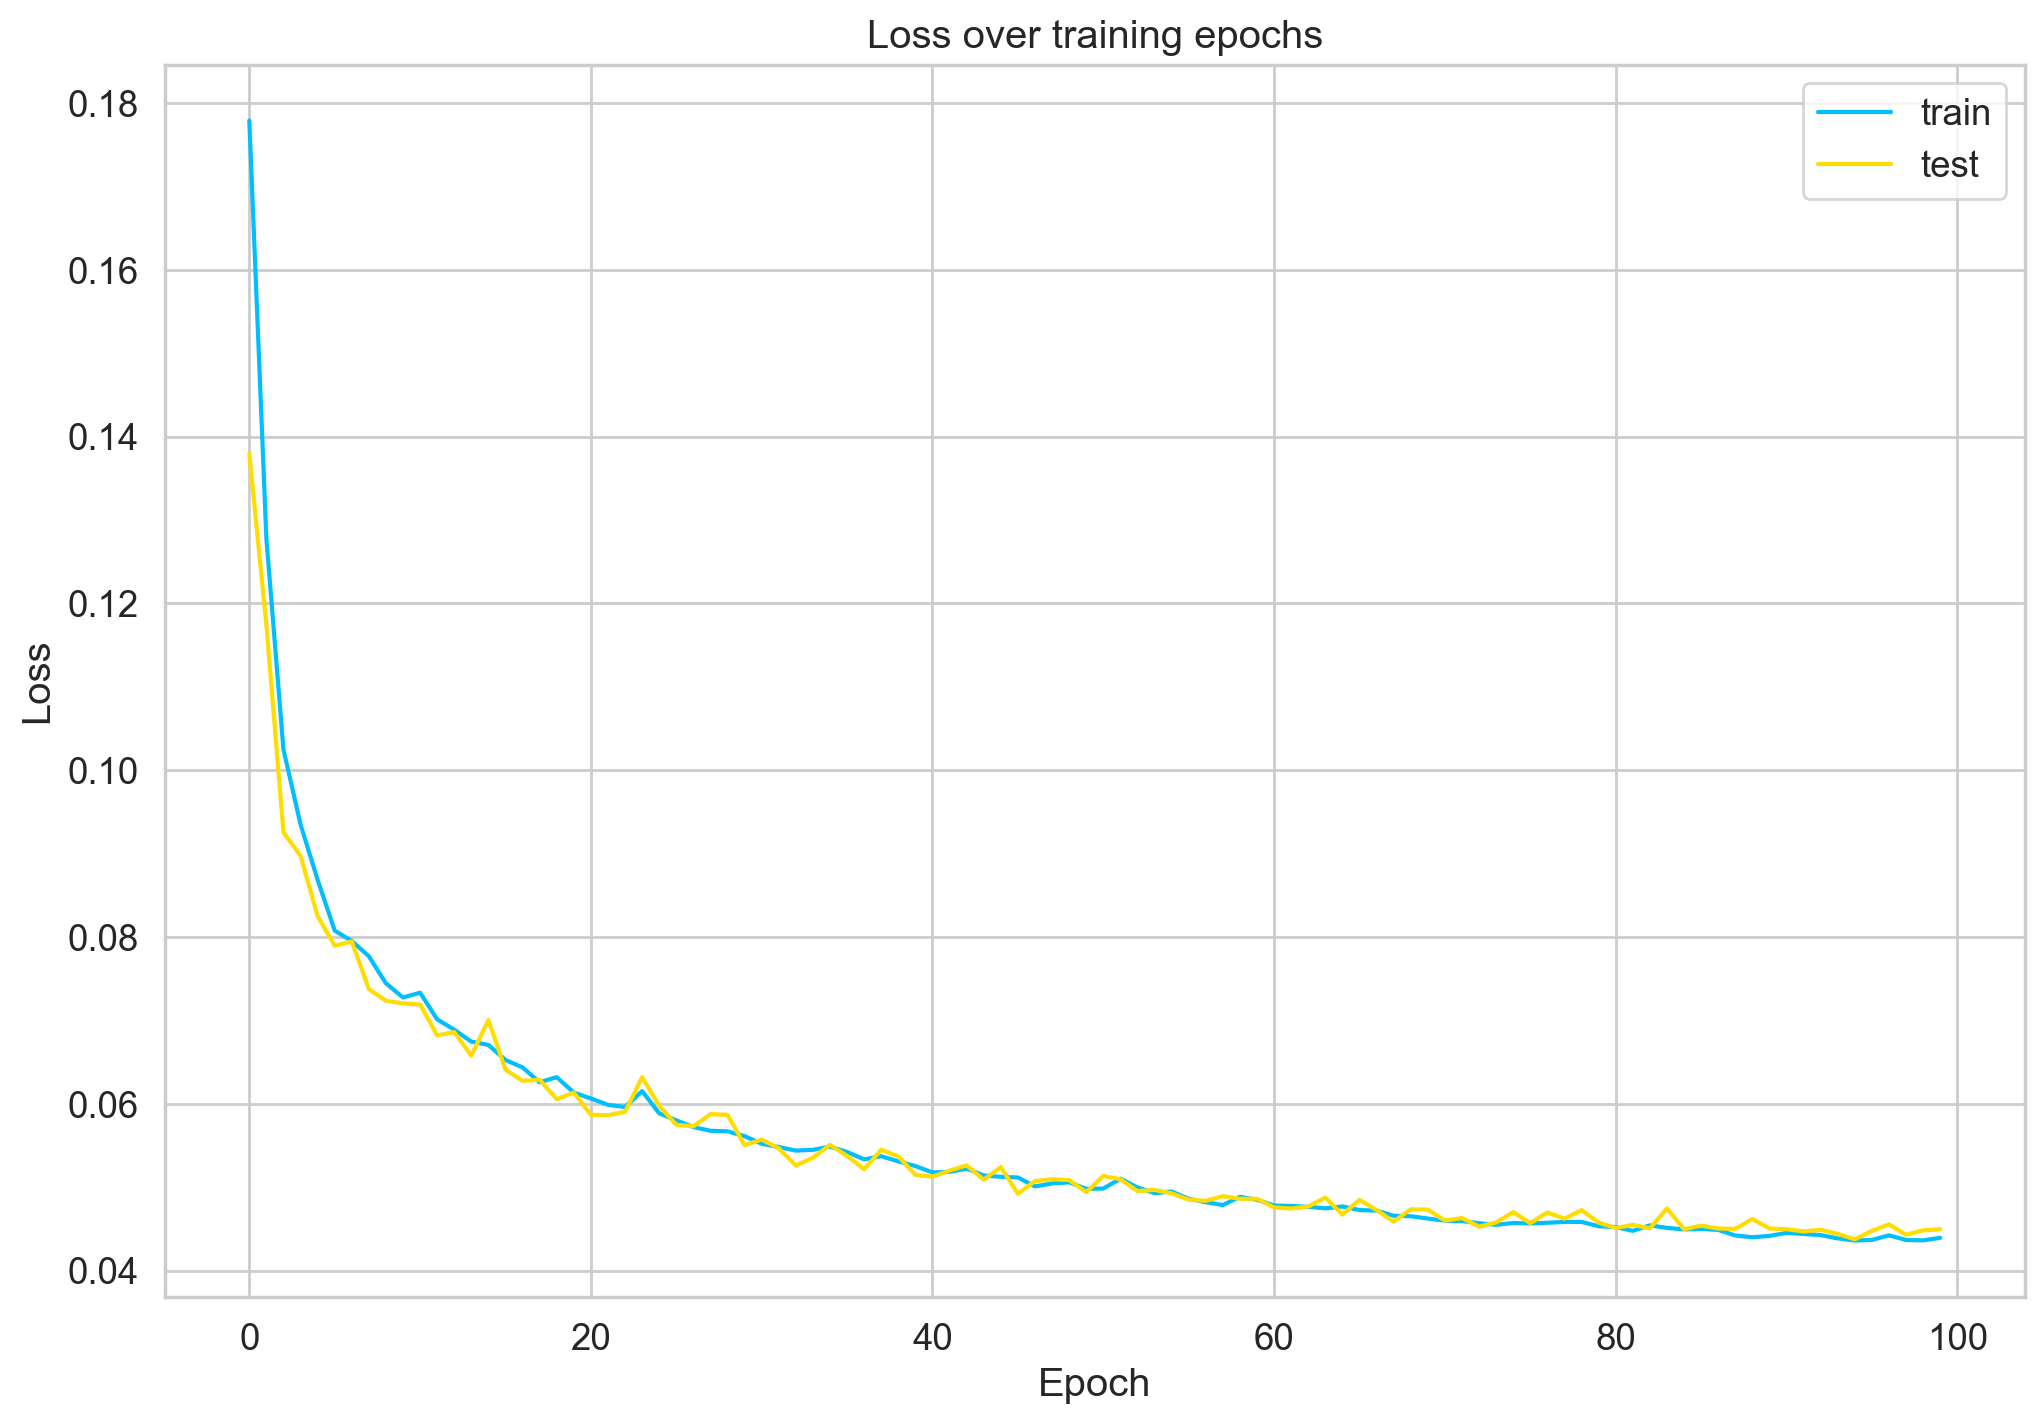

In [98]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [99]:
embedding_list = {}
output_list = {}
with torch.no_grad():
    for in_seq,tar_seq,action,vid_size in tqdm(test_dl):
        in_seq = in_seq.to(device)
        tar_seq = tar_seq.to(device)
        seq_pred,embedding  = model(in_seq)

        for seq,emb,action in zip(seq_pred.unbind(0),embedding.unbind(0),action.unbind(0)):
                try:
                    if len(embedding_list[int(action)])<=50:
                        embedding_list[int(action)].append(emb)
                        output_list[int(action)].append(seq)
                except KeyError:
                    embedding_list[int(action)] = [emb]
                    output_list[int(action)] = [emb]

        
            
        
        #embedding_list[]

100%|██████████| 45/45 [00:36<00:00,  1.24it/s]


In [100]:
def draw_heatmaps(arr_list,nrows=2,ncols=2):
    ran_list = random.sample(arr_list,ncols*nrows)
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols, sharex=True)
    for i in range(nrows):
        for j in range(ncols):
            #print(i*ncols+j,len(ran_list))
            ax[i,j].imshow(ran_list[i*ncols+j].detach().cpu().numpy()[np.newaxis,:], cmap="plasma", aspect="auto")

    plt.tight_layout()
    plt.show()

In [101]:
draw_heatmaps(embedding_list[11])

ValueError: Sample larger than population or is negative

In [ ]:
draw_heatmaps(embedding_list[22])

In [ ]:
draw_heatmaps(embedding_list[16])

In [ ]:
def gen_video_from_embeddings(embedding,model,save_file):
    seq_out = model.decoder(embedding.repeat(batch_size,1,1))
    gen_video(seq_out[0].detach().numpy(), save_file, 400, 400)

In [ ]:
with torch.no_grad():
    for __id,(in_seq,tar_seq,action,vid_size) in tqdm(enumerate(test_dl)):
        in_seq = in_seq.to(device)
        tar_seq = tar_seq.to(device)
        seq_pred,embedding  = model(in_seq)

        for __id,(input_vid,output_vid,action) in enumerate(zip(in_seq.unbind(0),seq_pred.unbind(0),action.unbind(0))):
            os.makedirs(f"{test_vids}/{int(action)}",exist_ok=True)

            

        
            
        
        #embedding_list[]

In [ ]:
gen_video_from_embeddings(embedding_list[4][10],model,"embed_video.mp4")

In [ ]:
test_emb = 0.5*embedding_list[19][0]+0.5*embedding_list[16][0]
gen_video_from_embeddings(test_emb,model,"test_embed_video.mp4")